# Lab 1: Proximal Denoising

Welcome to the advanced Large Scale Distributed Optimisation Course.

The objective of this lab session is to handle proximal denoising by denoising an image using wavelets.

We begin with the standard imports:

In [1]:
import numpy as np
import cv2
import pywt
import time
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import tqdm

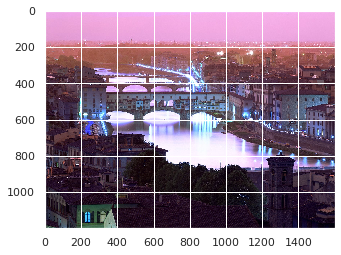

In [2]:
im = cv2.imread('florence.jpg')
plt.imshow(im)

Let's add some random gaussian noise to our image :

Text(0.5, 1.0, 'Noisy image  MSE=0.2075')

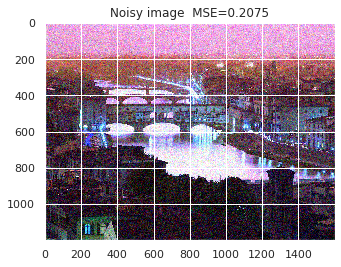

In [3]:
im_noise = im + np.random.normal(0,30,size=im.shape)
im_noise = np.clip(im_noise, 0, 255).astype('int')
plt.imshow(im_noise)
plt.title('Noisy image  MSE={:.4f}'.format(np.linalg.norm(im - im_noise)/np.linalg.norm(im)))

In [4]:
penalizations = {}

penalizations['1'] = lambda eps, chi: np.multiply(np.sign(eps), np.maximum(abs(eps)-chi,np.zeros(eps.shape)))
penalizations['4/3'] = lambda eps, chi: eps + 4*chi * (np.power(np.sqrt(np.power(eps,2)+256*chi**3/729) - eps, 1/3) - 
                                                     np.power(np.sqrt(np.power(eps,2)+256*chi**3/729) + eps, 1/3)) / (3*2**(1/3))
penalizations['3/2'] = lambda eps, chi: eps + np.multiply(9*chi**2*np.sign(eps), 
                                                        1 - np.sqrt(1+16*abs(eps)/(9*chi**2))) / 8
penalizations['2'] = lambda eps, chi: eps / (1 + 2*chi)
penalizations['3'] = lambda eps, chi: np.multiply(np.sign(eps), 
                                                (np.sqrt(1+12*chi*abs(eps)) - 1) / (6*chi))
penalizations['4'] = lambda eps, chi: (np.power((np.sqrt(np.power(eps,2)+1/(27*chi)) + eps)/(8*chi), 1/3) - 
                                     np.power((np.sqrt(np.power(eps,2)+1/(27*chi)) - eps)/(8*chi), 1/3))

### Preliminary Experiments

6it [00:06,  1.03s/it]


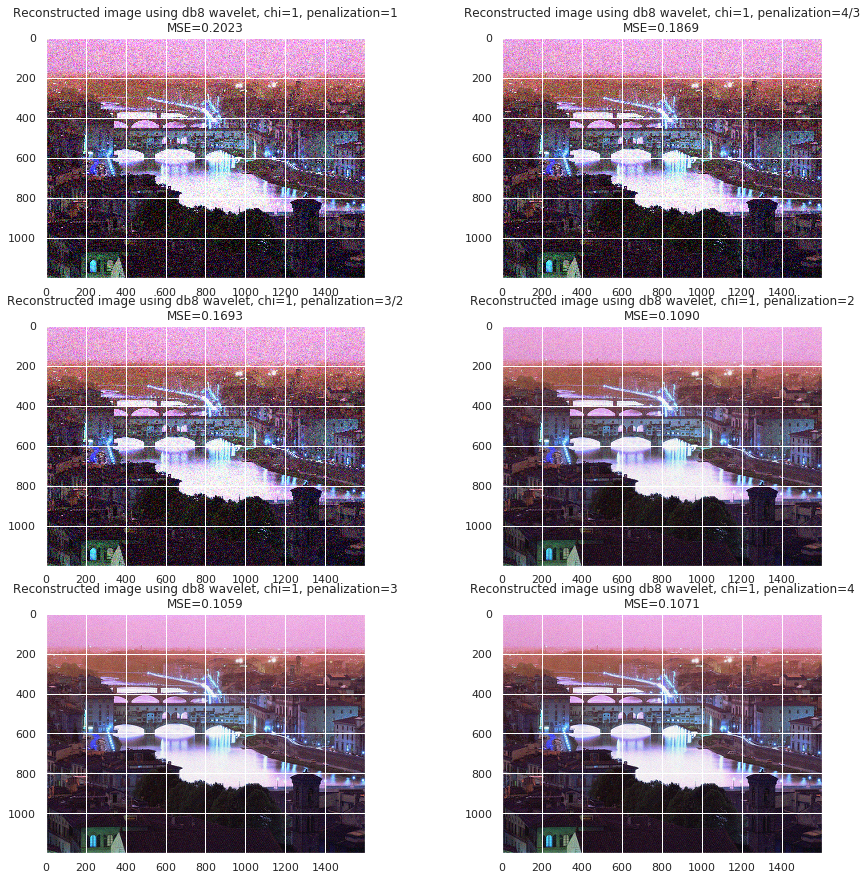

In [5]:
plt.figure(figsize=(15,15))

# Define the parameters
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = 1

for index, pen in tqdm.tqdm(enumerate(penalization_types)):
    L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
    prox_L = [L[0],[penalizations[pen](coef,chi) for coef in L[1]], 
              [penalizations[pen](coef,chi) for coef in L[2]]]
    reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
    reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
    plt.subplot(3, len(penalization_types)//3, index+1)
    plt.title('Reconstructed image using {} wavelet, chi={}, penalization={}\nMSE={:.4f}'.format('db8',chi,pen,
                                                np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)))
    plt.imshow(reconstructed_im)

#### Observation: 
We observe that for a given $\chi$ the results can vary a lot depending on $q$.  With the $q$ parameter of the penalization equal to 1, we have a poor denoising effect (MSE between noisy and original image is closed to the MSE between denoised and original images). On the opposite, with the $q$ parameter of the penalization equal to 3 the MSE is nearly divided by 2 when compared to the former configuration.  

#### Discussion: 
It is important to highlight that the previous experiments were made with the same $\chi$, therefore the value used can be closer to the optimal value depending on the $q$ value. For a more relevant comparison between the different regularization, it is important to set the $\chi$ value more carefully.



### Choosing the value for $\chi$ 

#### Grid Search Method 

First, we can try to find an optimal value for $\chi$ using regularly sampled value from a segment and take the best value. 

1/6
It took 34 seconds to finish this iteration.
--------------------------------------------------
2/6
It took 75 seconds to finish this iteration.
--------------------------------------------------
3/6
It took 34 seconds to finish this iteration.
--------------------------------------------------
4/6
It took 30 seconds to finish this iteration.
--------------------------------------------------
5/6
It took 33 seconds to finish this iteration.
--------------------------------------------------
6/6
It took 74 seconds to finish this iteration.
--------------------------------------------------
1/2
It took 68 seconds to finish this iteration.
--------------------------------------------------
2/2
It took 153 seconds to finish this iteration.
--------------------------------------------------


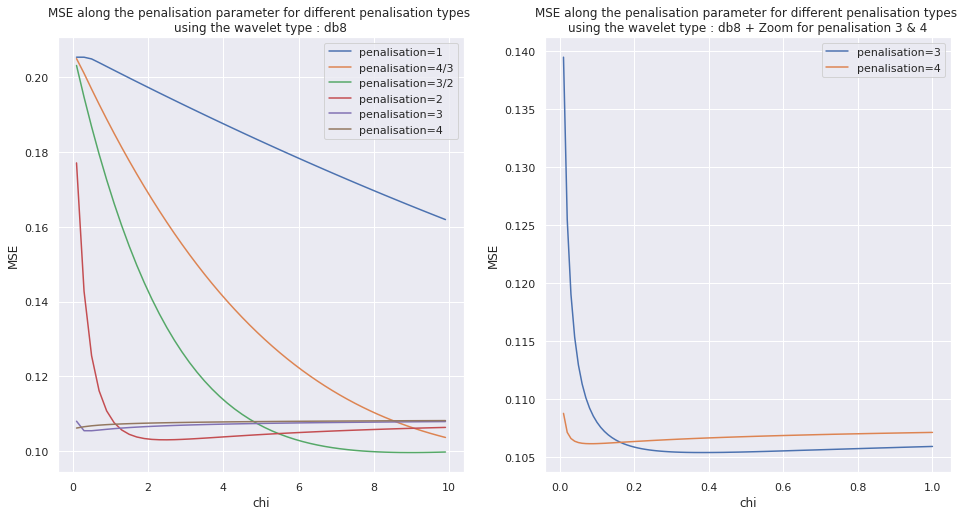

In [6]:
plt.figure(figsize=(16,8))

# Define the parameters
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = [k/10 for k in range(1,101,2)]

ax = plt.subplot(121)
for itr, pen in enumerate(penalization_types):
    print(str(itr+1)+'/6')
    start = time.time()
    MSE = []
    for param in chi:
        L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
        prox_L = [L[0],[penalizations[pen](coef,param) for coef in L[1]], 
                  [penalizations[pen](coef,param) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        MSE.append(np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im))
    plt.plot(chi, MSE, label='penalisation={}'.format(pen))
    end = time.time()
    print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)
    
plt.legend()
plt.xlabel("chi")
plt.ylabel("MSE")
plt.title("MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : db8")
    

chi = [k/100 for k in range(1,101)]

ax = plt.subplot(122)
for itr, pen in enumerate(penalization_types[-2:]):
    print(str(itr+1)+'/2')
    start = time.time()
    MSE = []
    for param in chi:
        L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
        prox_L = [L[0],[penalizations[pen](coef,param) for coef in L[1]], 
                  [penalizations[pen](coef,param) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        MSE.append(np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im))
    plt.plot(chi, MSE, label='penalisation={}'.format(pen))
    end = time.time()
    print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)
    
    
plt.legend()
plt.xlabel("chi")
plt.ylabel("MSE")
plt.title("MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : db8 + Zoom for penalisation 3 & 4")


plt.show()

It appears that this solution is slow and that the segment to sample the value from is diffcult to chose. For this reason, we will try a different method to find a better estimate of the optimal value in a shorter time.

#### Relation between $\chi$ and the MSE 
First, we are interested in the shape of the function $\chi \mapsto MSE(\chi)$. We will visualize the shape of for  $q=1$ and using db8 wavelet and assume that the shape with the other parameters are similar and that only the scale and window size varies. 

100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Text(0.5, 1.0, 'MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : db8')

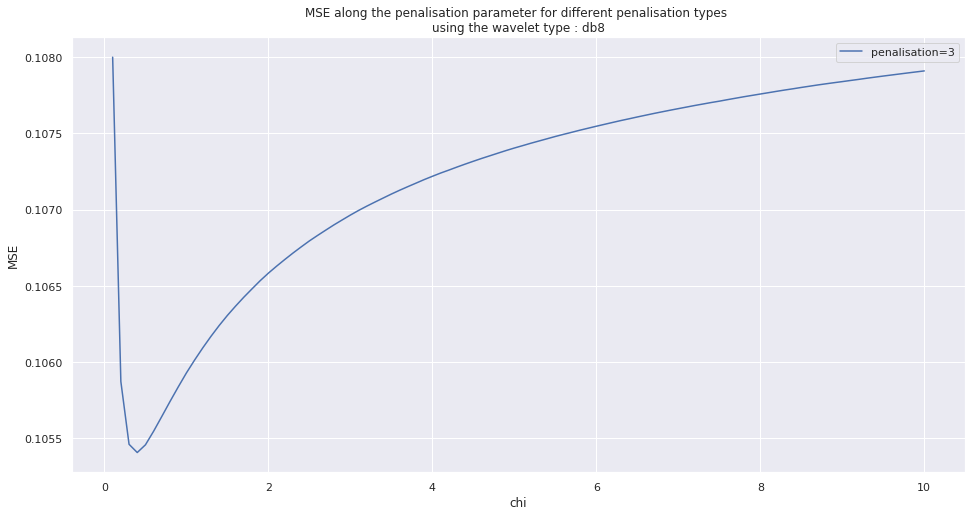

In [7]:
fg, ax =  plt.subplots(1,1, figsize=(16,8))
L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
chis = [c/10 for c in range(1,101,1)]
pen = '3'
MSE = []
for chi in tqdm.tqdm(chis):
    prox_L = [L[0],[penalizations[pen](coef,chi) for coef in L[1]], 
          [penalizations[pen](coef,chi) for coef in L[2]]]
    reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
    reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
    MSE.append(np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im))
ax.plot(chis, MSE, label='penalisation={}'.format(pen))
ax.legend()
ax.set_xlabel("chi")
ax.set_ylabel("MSE")
ax.set_title("MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : db8")
    

#### Observation: 
The curve is very regular and seems to be decreasing until it reaches a unique minimun (which is the only local minima) and then re-increases. 

#### Discussion: 
Assuming that the shape of the curve is similar for the other $q$, one can use a simple method to find a value of $\chi$ close to the optimal value. 

#### Choosing $\chi$ for each value of $q$

With a fixed number of evaluation $n$ we want to get closer to the mimimum. 

To solve this probleme one can use the gloden section search method.
We assume that we the minimum of  $\chi \mapsto MSE(\chi)$ is between two value $a,b$ (one can just take a small enough value for $a$ and a high enough value for $b$). 


We initialize the algortihme with $\chi_0 = a$ and $\chi_3 = b$. 


At each iteration, we take 2 values for $\chi$ subject to 
$$\chi_1 = \chi_0 + \frac{3- \sqrt{5}}{2}(\chi_3 - \chi_0)$$ 
$$\chi_2 = \chi_0 + \frac{\sqrt{5}-1}{2}(\chi_3 - \chi_0)$$ 
then if  $MSE(\chi_1)< MSE(\chi_2)$ : we iterate with $\chi_3 :=\chi_2$ else $\chi_0 := \chi_1$ 

Under the assumption that the curves are similar for every $q$ (ie they all have only one local minima) and that the initialization segment is big enough, we approximate the optimal value for $\chi$

It took 8 seconds to finish this iteration.
--------------------------------------------------
It took 25 seconds to finish this iteration.
--------------------------------------------------
It took 8 seconds to finish this iteration.
--------------------------------------------------
It took 7 seconds to finish this iteration.
--------------------------------------------------
It took 8 seconds to finish this iteration.
--------------------------------------------------
It took 25 seconds to finish this iteration.
--------------------------------------------------


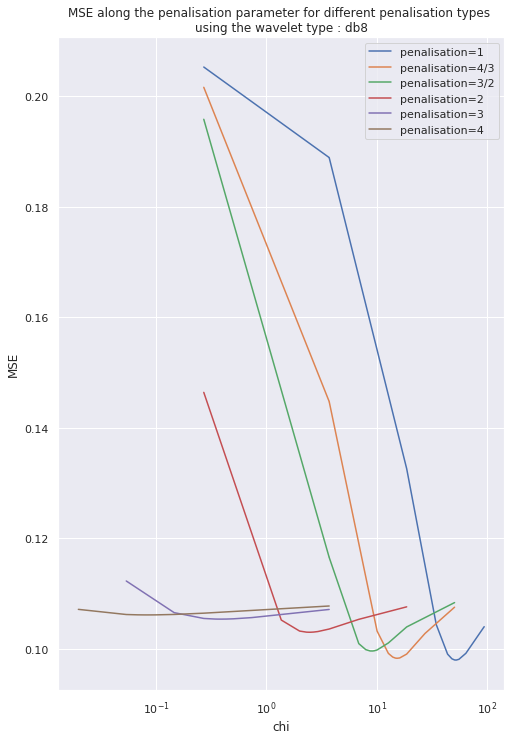

In [8]:

gamma = [(3 - np.sqrt(5))/2 , (np.sqrt(5)-1)/2 ]
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
best_chi = {}
for pen in penalization_types: 
    best_chi[pen] = None
it_max = 10
tol = 1e-8
fg , ax = plt.subplots(1,1,figsize=(8,12))
ax.set_xscale('log')
L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
for itr, pen in enumerate(penalization_types):
    start = time.time()
    x0, x3 = [-8, 8] 
    MSE = []
    chis = []
    it = 0
    converged = False
    while not converged and (it < it_max):
        it=it+1
        x1 = x0 + gamma[0] * (x3 - x0)
        x2 = x0 + gamma[1] * (x3 - x0)
        prox_L = [L[0],[penalizations[pen](coef,2**x1) for coef in L[1]], 
                      [penalizations[pen](coef,2**x1) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        mse_1 = np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)
        chis.append(2**x1)
        MSE.append(mse_1)
        
        prox_L = [L[0],[penalizations[pen](coef,2**x2) for coef in L[1]], 
                      [penalizations[pen](coef,2**x2) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        mse_2 = np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)
        chis.append(2**x2)
        MSE.append(mse_2)
        if best_chi[pen] is None : 
            best_chi[pen] = (2**x2, mse_2)
        elif best_chi[pen][1] > mse_2 : 
            best_chi[pen] = (2**x2, mse_2)
            
        converged = (abs(mse_2- mse_1)<tol)
        if mse_1 < mse_2 : 
            x0, x3 = x0, x2
        else: 
            x0, x3 = x1, x3
    if converged :
        print('optimal value reached for : penalisation={} and db8 wavelet'.format(pen))
    vals = list(zip(chis,MSE))
    vals.sort(key = lambda x : x[0])
    vals = np.asarray(vals)
    ax.plot(vals[:,0], vals[:,1], label='penalisation={}'.format(pen))
    end = time.time()
    print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)


ax.legend()

ax.set_xlabel("chi")
ax.set_ylabel("MSE")
ax.set_title("MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : db8")
plt.show()

6it [00:05,  1.01it/s]


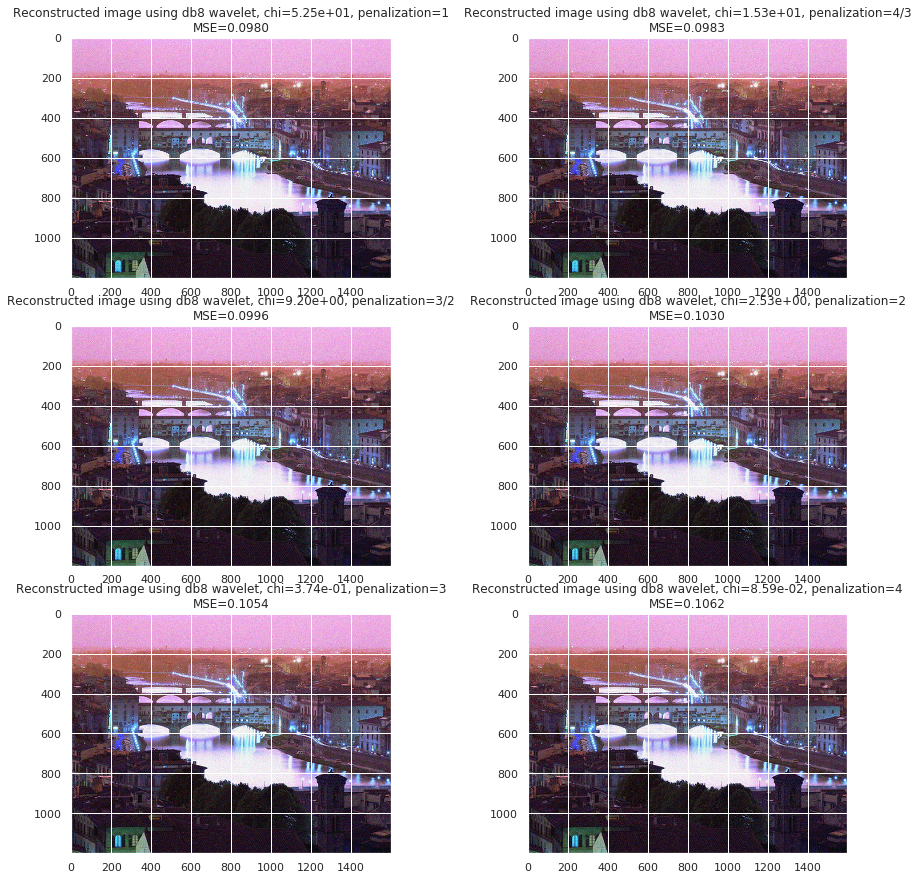

In [9]:
plt.figure(figsize=(15,15))

# Define the parameters
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = 1

for index, pen in tqdm.tqdm(enumerate(penalization_types)):
    L = pywt.wavedec2(im_noise,'db8',level=2,axes=(0,1))
    prox_L = [L[0],[penalizations[pen](coef,best_chi[pen][0]) for coef in L[1]], 
              [penalizations[pen](coef,best_chi[pen][0]) for coef in L[2]]]
    reconstructed_im = pywt.waverec2(prox_L,'db8',axes=(0,1))
    reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
    plt.subplot(3, len(penalization_types)//3, index+1)
    plt.title('Reconstructed image using {} wavelet, chi={:.2e}, penalization={}\nMSE={:.4f}'.format('db8',best_chi[pen][0],pen,
                                                np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)))
    plt.imshow(reconstructed_im)

#### Observation 
It appears that setting the parameters to an optimal value improves greatly the results for the different regularizations. We can also notice that the regularization type that were performing the best with an arbitrary value of $\chi$ are in fact the flatest curves and benefits the less from the optimization of $\chi$. 

Moreover, the results are quickly reached which allows us to try different parameters for the wavelet transforms and to do comparisons between the optimal regularization for each wavelet basis.

In [ ]:
wavelet_types = ['db8', 'haar', 'coif2', 'sym2']
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = [k/10 for k in range(1,101)]

fg, ax  = plt.subplots(len(wavelet_types),1, figsize=(12,12))
for i, wav in enumerate(wavelet_types):
    for itr, pen in enumerate(penalization_types):
        start = time.time()
        x0, x3 = [-8, 8] 
        MSE = []
        chis = []
        it = 0
        converged = False
        while not converged and (it < it_max):
            it=it+1
            x1 = x0 + gamma[0] * (x3 - x0)
            x2 = x0 + gamma[1] * (x3 - x0)
            prox_L = [L[0],[penalizations[pen](coef,2**x1) for coef in L[1]], 
                          [penalizations[pen](coef,2**x1) for coef in L[2]]]
            reconstructed_im = pywt.waverec2(prox_L,wav,axes=(0,1))
            reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
            mse_1 = np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)
            chis.append(2**x1)
            MSE.append(mse_1)

            prox_L = [L[0],[penalizations[pen](coef,2**x2) for coef in L[1]], 
                          [penalizations[pen](coef,2**x2) for coef in L[2]]]
            reconstructed_im = pywt.waverec2(prox_L,wav,axes=(0,1))
            reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
            mse_2 = np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im)
            chis.append(2**x2)
            MSE.append(mse_2)
            if best_chi[pen] is None : 
                best_chi[pen] = (2**x2, mse_2)
            elif best_chi[pen][1] > mse_2 : 
                best_chi[pen] = (2**x2, mse_2)

            converged = (abs(mse_2- mse_1)<tol)
            if mse_1 < mse_2 : 
                x0, x3 = x0, x2
            else: 
                x0, x3 = x1, x3
        if converged :
            print('optimal value reached for : penalisation={} and {} wavelet'.format(pen, wav))
        vals = list(zip(chis,MSE))
        vals.sort(key = lambda x : x[0])
        vals = np.asarray(vals)
        ax.flatten()[i].plot(vals[:,0], vals[:,1], label='penalisation={}'.format(pen))
        end = time.time()
        print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)


    ax.flatten()[i].legend()

    ax.flatten()[i].set_xlabel("chi")
    ax.flatten()[i].set_ylabel("MSE")
    ax.flatten()[i].set_title("MSE along the penalisation parameter for different penalisation types \nusing the wavelet type : {}".format(wav))
    plt.show()

It took 7 seconds to finish this iteration.
--------------------------------------------------
It took 24 seconds to finish this iteration.
--------------------------------------------------
It took 8 seconds to finish this iteration.
--------------------------------------------------
It took 6 seconds to finish this iteration.
--------------------------------------------------


1/4


KeyboardInterrupt: 

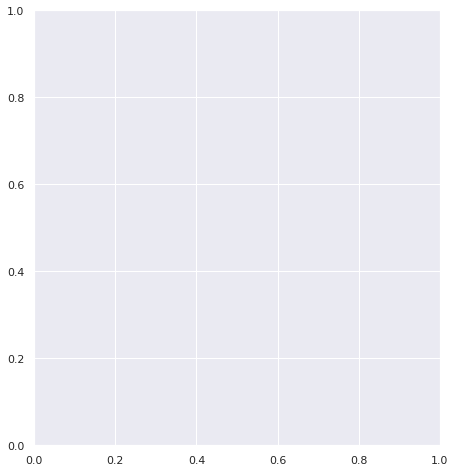

In [10]:
plt.figure(figsize=(16,8))

# Define the parameters
wavelet_types = ['db8', 'haar', 'coif2', 'sym2']
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = [k/10 for k in range(1,101)]

fg, ax  = plt.subplots(len(wavelet_types),1, figsize=12,12)
for itr, wav in enumerate(wavelet_types):
    print(str(itr+1)+'/4')
    start = time.time()
    MSE = []
    for param in chi:
        L = pywt.wavedec2(im_noise,wav,level=2,axes=(0,1))
        prox_L = [L[0],[penalizations['2'](coef,param) for coef in L[1]], 
                  [penalizations['2'](coef,param) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,wav,axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        MSE.append(np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im))
    ax.flatten()[itr].plot(chi, MSE, label='wavelet type = {}'.format(wav))
    end = time.time()
    print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)

plt.legend()
plt.xlabel("Chi")
plt.ylabel("MSE")
plt.title("MSE along the penalisation parameter for different wavelet types \nusing the penalisation type : 2")


plt.show()

If you want to know which are the possible wavelets that you can use :

In [ ]:
pywt.wavelist()

In [ ]:
plt.figure(figsize=(16,8))

# Define the parameters
wavelet_types = ['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10']
penalization_types = ['1', '4/3', '3/2', '2', '3', '4']
chi = [k/10 for k in range(1,51)]

plt.subplot(121)
for itr, wav in enumerate(wavelet_types):
    print(str(itr+1)+'/10')
    start = time.time()
    MSE = []
    for param in chi:
        L = pywt.wavedec2(im_noise,wav,level=2,axes=(0,1))
        prox_L = [L[0],[penalizations['2'](coef,param) for coef in L[1]], 
                  [penalizations['2'](coef,param) for coef in L[2]]]
        reconstructed_im = pywt.waverec2(prox_L,wav,axes=(0,1))
        reconstructed_im = np.clip(reconstructed_im, 0, 255).astype('int')
        MSE.append(np.linalg.norm(im - reconstructed_im)/np.linalg.norm(im))
    plt.plot(chi, MSE, label='wavelet type = {}'.format(wav))
    end = time.time()
    print('It took {:.0f} seconds to finish this iteration.\n'.format(end-start)+'-'*50)

plt.legend()
plt.xlabel("Chi")
plt.ylabel("MSE")
plt.title("MSE along the penalisation parameter for different wavelet types \nusing the penalisation type : 2")

plt.show()